In [113]:
#Import Necessary libraries
suppressWarnings({
library('tidyverse')
library('dplyr')
library('quantregForest')
source('functions.R')
})

In [53]:
train = readRDS("04a-wrangledTrain.rds")
holdout = readRDS("04b-wrangledHoldout.rds")
lm_model_full = readRDS("05a-lm.rds")
interact_model_full = readRDS("05e-lmInteractions.rds")
interact_model_subset = readRDS("05e-subsetlmInteractions.rds")
RF_full = readRDS("05d-RF.rds")

In [98]:
trees_full = readRDS("05c-tree.rds")

# Model Diagnostics
We will be trying to fit various diagnostic plots to assess the quality of the our models 

In [87]:
#' @description
#' function which returns a residual plot for the given model
#'
#' @param model - model for which the residual plot is being fitted, 
#'               needs to produce fitted and residual values when passed in fitted() & resid()
#' @param title - string for the title of the plot
#'
#' @return - residual plot with titles and labels 
res_plot= function(model, title){
    #produce residual vs. fitted plot
plot(predict(model), (log(train$price) - predict(model)), main=title,
        xlab="fitted value",
        ylab="residuals")

#add a horizontal line at 0 
abline(0,0)

    }

In [63]:
summary(train$price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1003    7500   14995   18614   26590  199999 

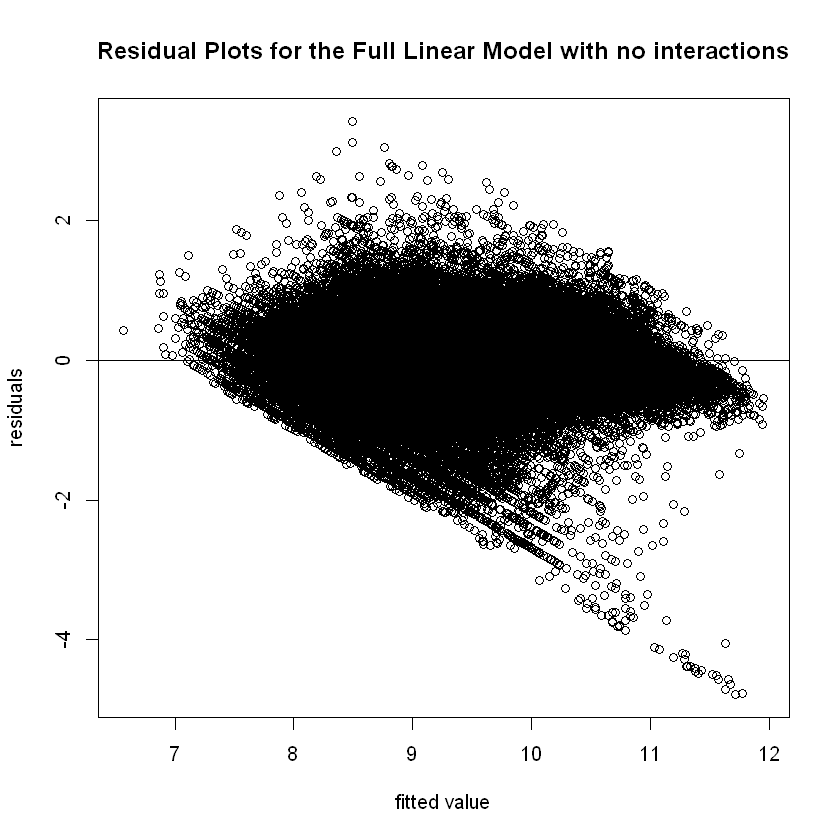

In [74]:
res_plot(lm_model_full, "Residual Plots for the Full Linear Model with no interactions")

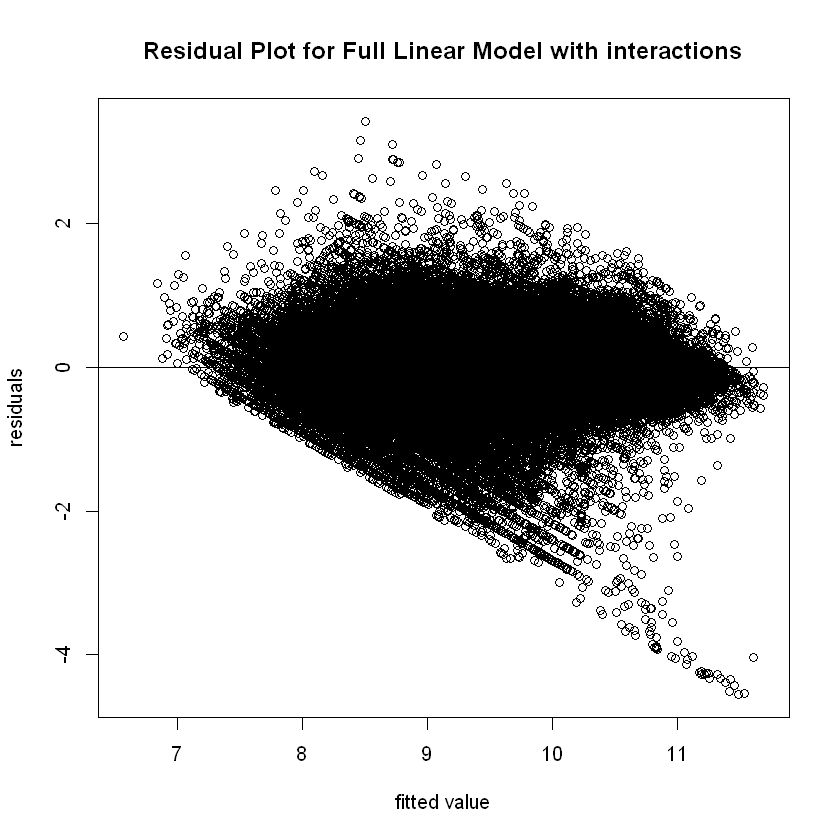

In [75]:
res_plot(interact_model_full, "Residual Plot for Full Linear Model with interactions")

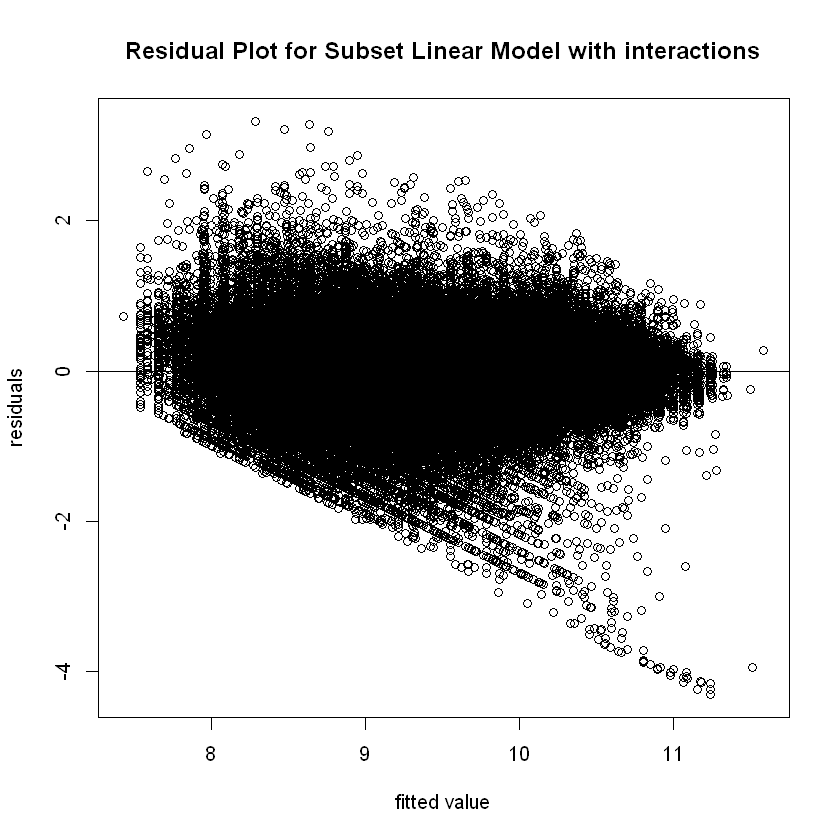

In [31]:
res_plot(interact_model_subset, "Residual Plot for Subset Linear Model with interactions")

In [32]:
lm_dummy_model = lm(price~., data = train)

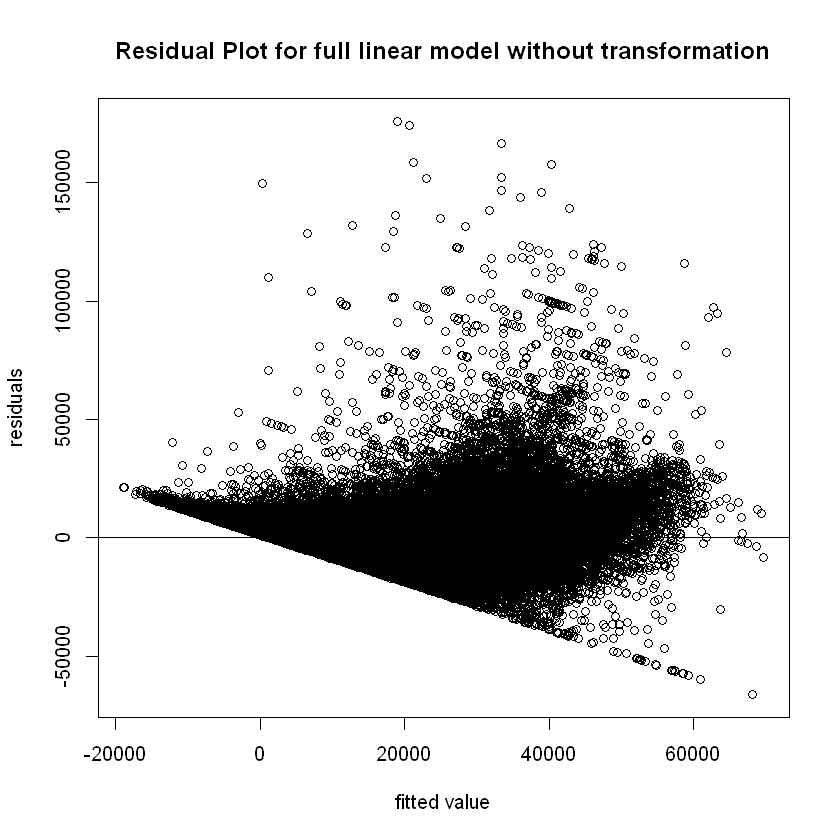

In [33]:
res_plot(lm_dummy_model, "Residual Plot for full linear model without transformation")

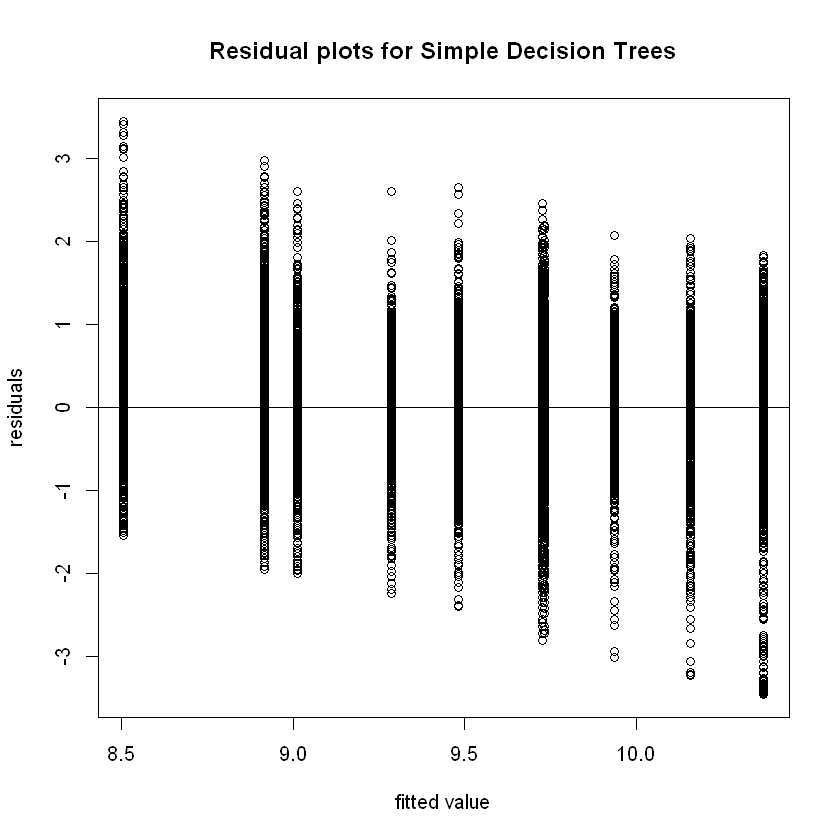

In [106]:
res_plot(trees_full, "Residual plots for Simple Decision Trees")

#### Making plots for trees and random forest and trees 

In [96]:
#saving rsiduals for random forest model
fitted =RF_full$predicted
res = RF_full$y-fitted

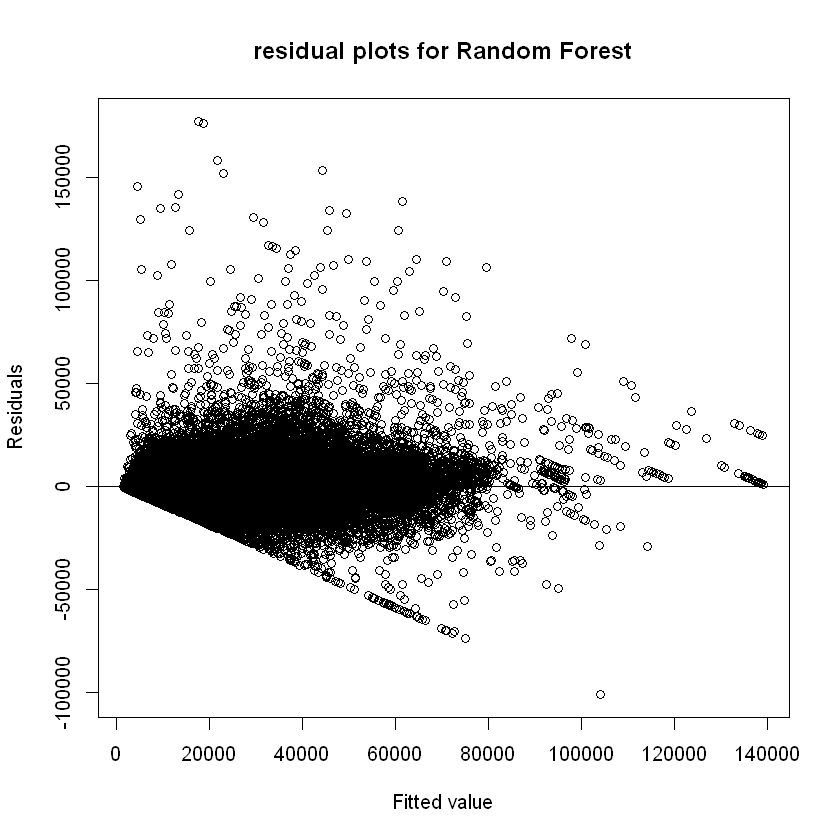

In [97]:
plot(fitted, res, main = "residual plots for Random Forest",
     xlab = "Fitted value",
     ylab = "Residuals")
abline(0,0)

In [91]:
head(predict(RF_full, what))

ERROR: Error in predict.quantregForest(RF_full): need to fit with option keep.inbag=TRUE 
 if trying to get out-of-bag observations


In [107]:
model_comp = function(model1, model2, title = "model1 vs model2"){
    plot(predict(model1), predict(model2), main=title,
        xlab="fitted value for model1",
        ylab="fitted value for model2")
    abline(0,1)}

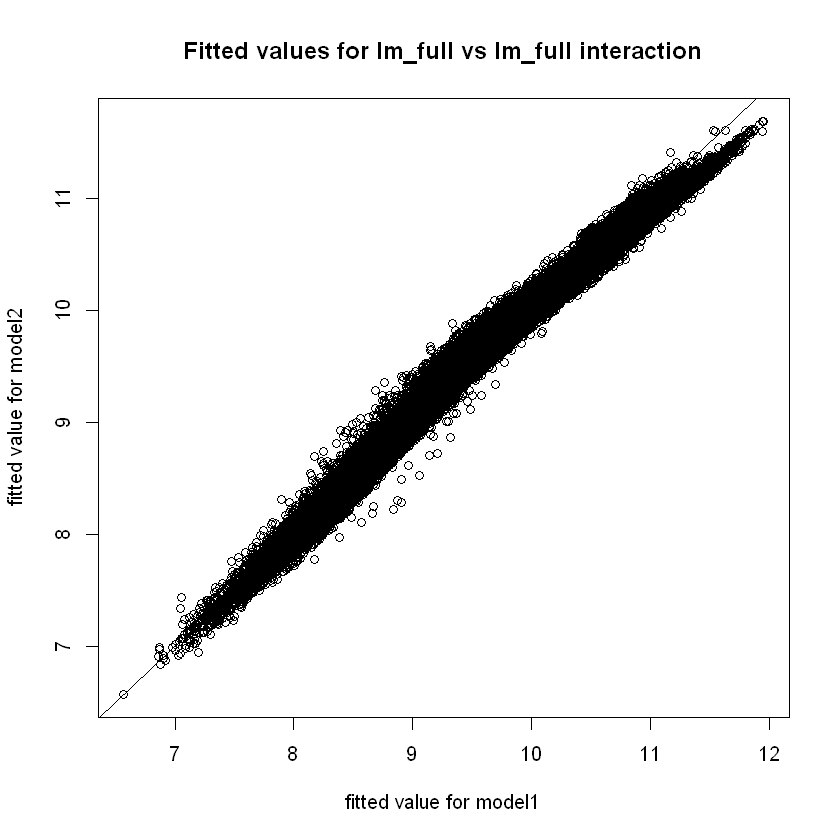

In [108]:
model_comp(lm_model_full, interact_model_full, "Fitted values for lm_full vs lm_full interaction")

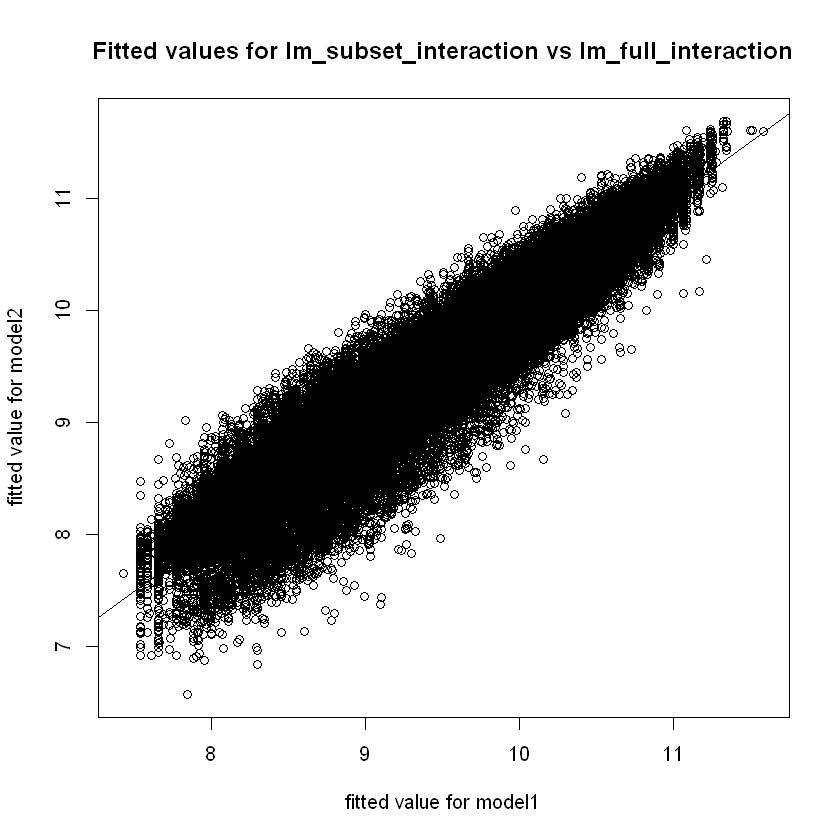

In [110]:
model_comp(interact_model_subset, interact_model_full, "Fitted values for lm_subset_interaction vs lm_full_interaction")

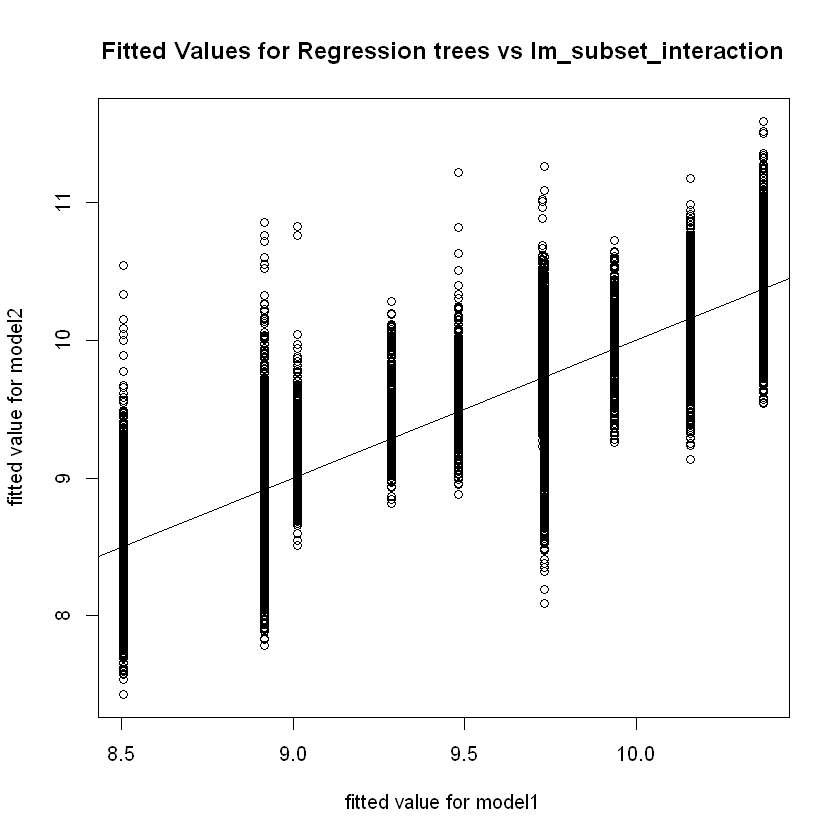

In [112]:
model_comp(trees_full, interact_model_subset, "Fitted Values for Regression trees vs lm_subset_interaction")

In [ ]:
### TODO add all other models explored

## Performance for out of sample holdout set

In [47]:
#' @description 
#' Function which returns interval score summary for given data and model
#' 
#' @param model - fitted model
#' @param data, dataset for which predicitons are made and IS is calculated - needs to contain `price`
#'
#' @return - returns summary for interval score with level, average interval length, interval score and coverage in order
validation_fn<- function(model, data){
    fitted = predict(model, newdata=data, interval="prediction", level=0.5)
    IS_summary = intervalScore(exp(fitted), data$price, level = 0.5)
    return(IS_summary)}

In [50]:
validation_fn(lm_model_full, holdout)

$summary
[1] 5.000000e-01 9.941950e+03 1.663217e+04 6.032687e-01

In [51]:
validation_fn(interact_model_full, holdout)

$summary
[1] 5.000000e-01 9.785666e+03 1.617115e+04 6.113481e-01

In [52]:
validation_fn(interact_model_subset, holdout)

$summary
[1] 5.000000e-01 1.075028e+04 1.786801e+04 5.919698e-01

##### find interval scores for trees

In [120]:
#' @description 
#' Function which returns interval score summary for given data and tree model
#' 
#' @param model - fitted tree model
#' @param data, dataset for which predicitons are made and IS is calculated - needs to contain `price`
#'
#' @return - returns summary for interval score with level, average interval length, interval score and coverage in order
validation_fn_tree<- function(RegTree, holdo){
   
        meanByTNode = tapply(log(train$price), RegTree$where, mean)
        Q25ByTNode = tapply(log(train$price), RegTree$where, quantile,prob=0.25)
        Q50ByTNode = tapply(log(train$price), RegTree$where, median)
        Q75ByTNode = tapply(log(train$price), RegTree$where, quantile,prob=0.75)

        meanpredRegTree = predict(RegTree, newdata=holdo,type="vector")
        TNodeGroup = FindUniquePos(meanpredRegTree,meanByTNode)
      
        TNodeGroup = FindUniquePos(meanpredRegTree,meanByTNode)
      
        Q25predRegTree = Q25ByTNode[TNodeGroup]; Q75predRegTree = Q75ByTNode[TNodeGroup]
        pred50IntRegTree = exp(cbind(meanpredRegTree,Q25predRegTree,Q75predRegTree))

        ISTree50 = intervalScore(pred50IntRegTree,holdo$price,0.5)
        return(ISTree50)}


In [121]:
validation_fn_tree(trees_full, holdout)

$summary
[1] 5.000000e-01 9.487919e+03 2.104811e+04 5.004716e-01